<img src="https://upload.wikimedia.org/wikipedia/commons/c/c7/HEIG-VD_Logo_96x29_RVB_ROUGE.png" alt="HEIG-VD Logo" width="250"/>

# TB - DevOps: Mise en place de cloud-native storage
## fio benchmark
**Note**: La version de fio utilisée pour chaque benchmark va être explicitement décrite tel que la license morale (section 4 [documentation](https://fio.readthedocs.io/en/latest/fio_doc.html#moral-license) fio) nous recommande.

Les tests se sont basés sur le benchmarking réalisé par Architecting-IT est accessible en [ligne](https://resources.storageos.com/downloadbenchmarkreport). Le benchmarking des différentes solutions ont réussi à démontré que StorageOs ressortait en tête parmi ses principaux concurrent en tant que solution de stockage block.

Ce que l'on va tenter de montrer est les différentes options proposées par Longhorn, essayer de comprendre son fonctionnement interne et voir si cela se manifeste dans notre benchmarking. 

Dans la méthodologie de test, on va montrer les différents déploiements utilisés (ce qui n'est pas fait dans le rapport par Architecting-IT) et proposer un déploiement via une image, ce qui aidera à la reproductibilité des tests effectués. Architecting-IT a effectué ses tests manuellement pour les raisons suivantes:
* To ensure that any lazy write process on file system creation didn’t affect the performance figures.
* To permit the validation of the container<->volume mapping and check the volume was the requisite size.
* To run iostat, top and iftop on each worker node. The output from these commands is not included but used to validate that there are no bottlenecks in CPU and network utilisation that could affect performance during test runs.

TODO demander à Marcel Graf si c'est grave? Est-ce que je devrais moi aussi run iostat+top+iftop pour guarantir qu'il n'y ait pas de CPU ou network bottleneck? 

On souhaite explorer les différents paramètres que Longhorn offre et voir leurs impacts dans les performances. Le hardware utilisé étant différent, on peut s'attendre à des résultats différents.

## Test en Local
Les résultats de cette section ont été généré à l'aide de fio version 3.16 à l'aide du script `run-all-jobs.sh`.

In [1]:
import json
# from: https://stackoverflow.com/a/3207973
from os import listdir
from os.path import isfile, join

fio_jobs_path = 'fio-jobs-output/local'
job_outputs_filename = [f for f in listdir(fio_jobs_path) if isfile(join(fio_jobs_path, f)) and 'output' in f]

In [2]:
job_outputs = []

# Load the results
for job_output in job_outputs_filename:
    f = open(f"{fio_jobs_path}/{job_output}")
    data = json.load(f)
    job_outputs.append(data)

print(job_outputs[0])

{'fio version': 'fio-3.16', 'timestamp': 1624716221, 'timestamp_ms': 1624716221209, 'time': 'Sat Jun 26 16:03:41 2021', 'global options': {'bs': '4K', 'iodepth': '256', 'direct': '1', 'ioengine': 'libaio', 'runtime': '120', 'numjobs': '4', 'size': '512M', 'name': 'raw-seqread', 'rw': 'read'}, 'jobs': [{'jobname': 'job1', 'groupid': 0, 'error': 0, 'eta': 0, 'elapsed': 121, 'job options': {'filename': '/dev/nvme0n1p7'}, 'read': {'io_bytes': 85691441152, 'io_kbytes': 83683048, 'bw_bytes': 714035839, 'bw': 697300, 'iops': 174325.156237, 'runtime': 120010, 'total_ios': 20920762, 'short_ios': 0, 'drop_ios': 0, 'slat_ns': {'min': 712, 'max': 318915, 'mean': 1345.356346, 'stddev': 891.144287}, 'clat_ns': {'min': 93938, 'max': 19756113, 'mean': 5872300.887986, 'stddev': 2146245.617705, 'percentile': {'1.000000': 1482752, '5.000000': 4014080, '10.000000': 4145152, '20.000000': 4227072, '30.000000': 4358144, '40.000000': 4489216, '50.000000': 5144576, '60.000000': 5406720, '70.000000': 7569408, '

## Test sur le cluster IICT
On souhaite déployer un container docker avec un PV dans le cluster IICT. Le container contient l'outil *fio* et un dossier *fio-jobs*.

Architecting-it a fait des [scripts](https://github.com/architectingit/k8sstorage/blob/main/perfraw.sh) pour réaliser ses tests. On va s'inspirer de leur script pour réaliser nos tests.

<u>**Connection au cluster IICT**</u>

Connectez-vous au VPN de l'école:
```bash
$ kubectl config get-contexts         # is ` iict ` listed ?
$ kubectl config use-context iict
```

<u>**Infrastructure testée**</u>

TODO mail à Rémi

### Benchmarking à la main
TODO refaire, edge case latency test output à pipe dans un fichier

Si vous désirer allez plus rapidement, sautez à la section suivante (on applique une configuration dans le cluster et récupère les résultats):

<u>**Déploiement**</u>

```bash
$ kubectl apply -f iict-fio-benchmark-manual.yaml
```

Observons quel classe de stockage sont disponibles :
```bash
$ kubectl get storageclass
NAME                 PROVISIONER                                     RECLAIMPOLICY   VOLUMEBINDINGMODE   ALLOWVOLUMEEXPANSION   AGE
longhorn (default)   driver.longhorn.io                              Delete          Immediate           true                   170d
nfs-client           cluster.local/nfs-subdir-external-provisioner   Delete          Immediate           true                   114d
```

Nous allons donc utiliser un PVC de storageclass `longhorn`.

<u>**Exécution des tests**</u>

Ensuite, on déploie un container simple:

```bash
$ kubectl apply --namespace=mercado -f iict-fio-benchmark-manual.yaml
```

On vérifie que le container a bien démarré:
```bash
$ kubectl get pods --namespace=mercado
```

On ouvre une session interactive et on install fio:
```bash
$ kubectl exec --namespace=mercado -it $(kubectl get pods --namespace=mercado -o=jsonpath='{.items[0].metadata.name}') -- /bin/sh
/ # apk add fio
/ # fio --version
$ exit # on sort de la session
```

On va copier un fio-job et un script permettant de run tous les tests:
```bash
# copy test script to pod
$ kubectl --namespace=mercado cp docker/iict/run-all-jobs.sh $(kubectl get pods --namespace=mercado -o=jsonpath='{.items[0].metadata.name}'):/

# copy all jobs to pod
$ kubectl --namespace=mercado cp docker/iict/fio-jobs/random-read.fio $(kubectl get pods --namespace=mercado -o=jsonpath='{.items[0].metadata.name}'):/
$ kubectl --namespace=mercado cp docker/iict/fio-jobs/random-readwrite.fio $(kubectl get pods --namespace=mercado -o=jsonpath='{.items[0].metadata.name}'):/
$ kubectl --namespace=mercado cp docker/iict/fio-jobs/random-write.fio $(kubectl get pods --namespace=mercado -o=jsonpath='{.items[0].metadata.name}'):/
$ kubectl --namespace=mercado cp docker/iict/fio-jobs/sequential-read.fio $(kubectl get pods --namespace=mercado -o=jsonpath='{.items[0].metadata.name}'):/
$ kubectl --namespace=mercado cp docker/iict/fio-jobs/sequential-readwrite.fio $(kubectl get pods --namespace=mercado -o=jsonpath='{.items[0].metadata.name}'):/
$ kubectl --namespace=mercado cp docker/iict/fio-jobs/sequential-write.fio $(kubectl get pods --namespace=mercado -o=jsonpath='{.items[0].metadata.name}'):/
```

Et on exécute les tests:
```bash
# ouvrir une session interactive
$ kubectl exec --namespace=mercado -it $(kubectl get pods --namespace=mercado -o=jsonpath='{.items[0].metadata.name}') -- /bin/sh
/ # sh run-all-jobs.sh
/ # exit
```

On récupère tous les outputs:
```shell
$ kubectl --namespace=mercado cp $(kubectl get pods --namespace=mercado -o=jsonpath='{.items[0].metadata.name}'):/random-read.fio-output fio-jobs/iict/random-read.fio-output
$ kubectl --namespace=mercado cp $(kubectl get pods --namespace=mercado -o=jsonpath='{.items[0].metadata.name}'):/random-readwrite.fio-output fio-jobs/iict/random-readwrite.fio-output
$ kubectl --namespace=mercado cp $(kubectl get pods --namespace=mercado -o=jsonpath='{.items[0].metadata.name}'):/random-write.fio-output fio-jobs/iict/random-write.fio-output
$ kubectl --namespace=mercado cp $(kubectl get pods --namespace=mercado -o=jsonpath='{.items[0].metadata.name}'):/sequential-read.fio-output fio-jobs/iict/sequential-read.fio-output
$ kubectl --namespace=mercado cp $(kubectl get pods --namespace=mercado -o=jsonpath='{.items[0].metadata.name}'):/sequential-readwrite.fio-output fio-jobs/iict/sequential-readwrite.fio-output
$ kubectl --namespace=mercado cp $(kubectl get pods --namespace=mercado -o=jsonpath='{.items[0].metadata.name}'):/sequential-write.fio-output fio-jobs/iict/sequential-write.fio-output
```

Une fois que l'on a terminé, on nettoie:
```bash
kubectl delete -f iict-fio-benchmark-manual.yaml
```

### Image

Nous allons déployer une image contenant les scripts de tests et un script d'exécution des tests en quelques lignes. On déploie :

```bash
$ kubectl apply -f iict-fio-benchmark.yaml
```

On peut observer l'exécution du container en consultant les logs (ou en allant sur l'UI rancher qui se rafraîchit automatiquement):
```bash
$ kubectl logs --follow $(kubectl get pods --namespace=mercado -o=jsonpath='{.items[0].metadata.name}') --namespace=mercado
```

Une fois que les logs affiche `"All jobs done"`, alors on peut récupérer les output et nettoyer les ressources:

```bash
$ sh iict-fio-benchmark-get-output.sh
$ kubectl delete -f iict-fio-benchmark.yaml
```

Maintenant on va visualiser nos données:

In [3]:
# from: https://stackoverflow.com/a/3207973
from os import listdir
from os.path import isfile, join

fio_jobs_path = 'docker/iict/fio-jobs'
job_outputs_filename = [f for f in listdir(fio_jobs_path) if isfile(join(fio_jobs_path, f))]

In [4]:
import json

job_outputs = []

# Load the results
for job_output in job_outputs_filename:
    f = open(f"fio-jobs-output/iict/deployment-01-fs/{job_output}-output")
    data = json.load(f)
    job_outputs.append(data)

print(job_outputs[0])

{'fio version': 'fio-3.27', 'timestamp': 1625731118, 'timestamp_ms': 1625731118200, 'time': 'Thu Jul  8 07:58:38 2021', 'global options': {'name': 'read_bw', 'rw': 'randread', 'randrepeat': '0', 'verify': '0', 'ioengine': 'libaio', 'direct': '1', 'gtod_reduce': '1', 'bs': '128K', 'runtime': '30s', 'iodepth': '16', 'fdatasync': '0', 'size': '250G', 'ramp_time': '10s', 'filename': '/data/fiotest'}, 'jobs': [{'jobname': 'architecting-it-test3-read-bandwidth', 'groupid': 0, 'error': 0, 'eta': 0, 'elapsed': 41, 'read': {'io_bytes': 422051840, 'io_kbytes': 412160, 'bw_bytes': 13798405, 'bw': 13475, 'iops': 104.783078, 'runtime': 30587, 'total_ios': 3205, 'short_ios': 0, 'drop_ios': 0, 'slat_ns': {'min': 0, 'max': 0, 'mean': 0.0, 'stddev': 0.0, 'N': 0}, 'clat_ns': {'min': 0, 'max': 0, 'mean': 0.0, 'stddev': 0.0, 'N': 0}, 'lat_ns': {'min': 0, 'max': 0, 'mean': 0.0, 'stddev': 0.0, 'N': 0}, 'bw_min': 768, 'bw_max': 35398, 'bw_agg': 99.881225, 'bw_mean': 13459.918033, 'bw_dev': 6693.517365, 'bw_s

##### Déploiement d'une nouvelle image

Pour mettre à jour l'image que le cluster peut utiliser pour benchmark (avec de nouveaux scénarios de tests ou des modifications), on tag un commit de ce repository avec, par exemple :

```bash
$ git tag # what tag can we use?
...
v0.1.4
v0.1.5
v0.1.6
v0.1.7

$ git tag v0.1.8
$ git push origin tag v0.1.8
```

On patiente un moment que l'image soit mise en ligne puis on peut réaliser notre benchmark.

**Note**: La github Action ne build que les images en `v0.*.*` pour le moment.

# Traîtement de l'output
En s'inspirant des 9 jobs fait par Architecting-IT, on va extraire les résultats:

In [5]:
deployments_filename = [f.split('.')[0] for f in listdir('deployments/')]

def deployment_output_folder_path(is_iict: bool, idx: int):
    """
    :param is_iict: true if the deployment is related to IICT
    :param idx: the deployment
    :return: the deployment folder path
    """
    folder = "local"
    if is_iict:
        folder = "iict"
    dep = ""
    for d in deployments_filename:
        if str(idx) in d:
            dep = d

    return f"fio-jobs-output/{folder}/{dep}"

print(deployment_output_folder_path(is_iict=True, idx=1))

fio-jobs-output/iict/deployment-01-fs


In [6]:
def deployment_output(deployment_output_folder: str):
    """
    :param deployment_output_folder:
    :return: a filtered view of all jobs with relevant metrics
    """
    output = {}
    output['deployment name'] = deployment_output_folder
    for f in listdir(deployment_output_folder):
        o = json.load(open(f"{deployment_output_folder}/{f}"))
        if o['global options']['name'] == 'read_iops':
            # iops_mean is a stop criteria?
            output['read_iops'] = o['jobs'][0]['read']['iops']
        if o['global options']['name'] == 'write_iops':
            output['write_iops'] = o['jobs'][0]['write']['iops']
        if o['global options']['name'] == 'read_bw':
            output['read_bw_mean'] = o['jobs'][0]['read']['bw_mean']
        if o['global options']['name'] == 'write_bw':
            output['write_bw_mean'] = o['jobs'][0]['write']['bw_mean']
        # TODO rerun jobs with gtod_reduce=0
        if o['global options']['name'] == 'read_latency':
            # slat: submission to kernel latency
            # clat: submission+completion latency
            # lat: TODO verify ~s+clat
            output['read_latency'] = o['jobs'][0]['read']['lat_ns']['mean']
        if o['global options']['name'] == 'write_latency':
             output['write_latency'] = o['jobs'][0]['write']['lat_ns']['mean']
        if o['global options']['name'] == 'seq_read':
            output['seq_read_bw'] = o['jobs'][0]['read']['bw_mean']
        if o['global options']['name'] == 'seq_write':
            output['seq_write_bw'] = o['jobs'][0]['write']['bw_mean']
        if o['global options']['name'] == 'rw_mix':
            output['rw_mix_read'] = o['jobs'][0]['read']['iops']
            output['rw_mix_write'] = o['jobs'][0]['write']['iops']
    return output

deployment_01 = deployment_output(deployment_output_folder_path(True, 1))
print(deployment_01)

{'deployment name': 'fio-jobs-output/iict/deployment-01-fs', 'seq_read_bw': 339834.409753, 'seq_write_bw': 371325.31694, 'write_iops': 4127.314278, 'rw_mix_read': 149.973625, 'rw_mix_write': 51.002242, 'read_latency': 497229907.238867, 'read_iops': 1502.93177, 'read_bw_mean': 13459.918033, 'write_bw_mean': 3454.12, 'write_latency': 7082972.685346}


## Graphiques
On veut réaliser une comparaison avec des graphiques sur les différentes métriques testées.

In [7]:
deployments = [
    deployment_output(deployment_output_folder_path(True, 1)),
    deployment_output(deployment_output_folder_path(True, 2)),
    deployment_output(deployment_output_folder_path(True, 3)),
    deployment_output(deployment_output_folder_path(True, 4)),
    deployment_output(deployment_output_folder_path(True, 5)),
    deployment_output(deployment_output_folder_path(True, 6)),
    deployment_output(deployment_output_folder_path(True, 7)),
    deployment_output(deployment_output_folder_path(True, 8)),
    deployment_output(deployment_output_folder_path(True, 9)),
]

deployments_name = [ d['deployment name'].split('0')[1] for d in deployments]

In [8]:
# default figure file type and dpi
figure_format = 'svg'
figure_dpi = 1200

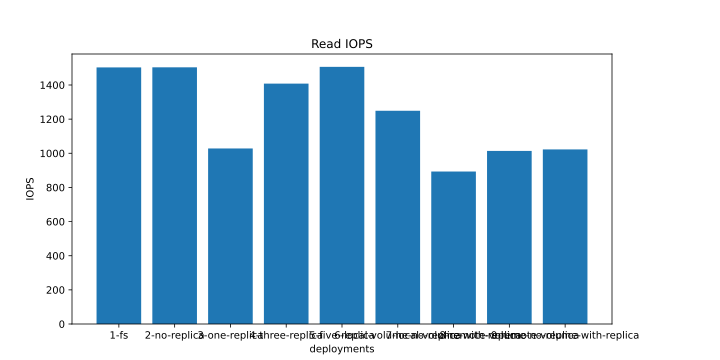

In [9]:
from matplotlib import pyplot as plt
plt.ioff()
from IPython.display import SVG, display

read_iops = [d['read_iops'] for d in deployments]
fig = plt.figure(figsize=(10,5))
# display legends: https://stackoverflow.com/a/19576608
ax = fig.add_axes([0.1,0.1,0.75,0.75])
ax.set_title('Read IOPS')
ax.set_xlabel('deployments')
ax.set_ylabel('IOPS')
bar = plt.bar(deployments_name, read_iops)
img_name = 'figures/read_iops.' + figure_format
plt.savefig(img_name, format=figure_format, dpi=figure_dpi)
display(SVG(img_name))

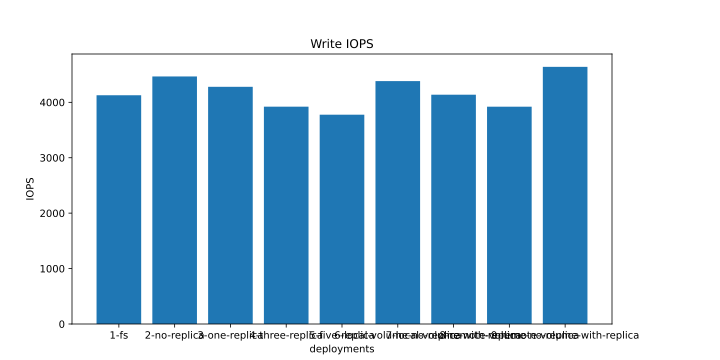

In [10]:
write_iops = [d['write_iops'] for d in deployments]
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0.1,0.1,0.75,0.75])
ax.set_title('Write IOPS')
ax.set_xlabel('deployments')
ax.set_ylabel('IOPS')
bar = plt.bar(deployments_name, write_iops)
img_name = 'figures/write_iops.' + figure_format
plt.savefig(img_name, format=figure_format, dpi=figure_dpi)
display(SVG(img_name))

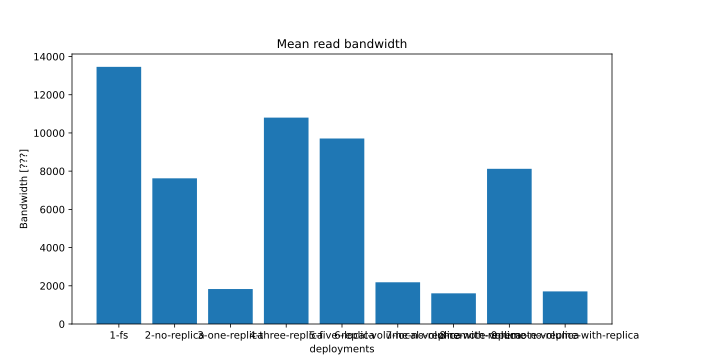

In [11]:
read_bw_means = [d['read_bw_mean'] for d in deployments]
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0.1,0.1,0.75,0.75])
ax.set_title('Mean read bandwidth')
ax.set_xlabel('deployments')
ax.set_ylabel('Bandwidth [???]') # TODO unit
bar = plt.bar(deployments_name, read_bw_means)
img_name = 'figures/read_bw_means.' + figure_format
plt.savefig(img_name, format=figure_format, dpi=figure_dpi)
display(SVG(img_name))

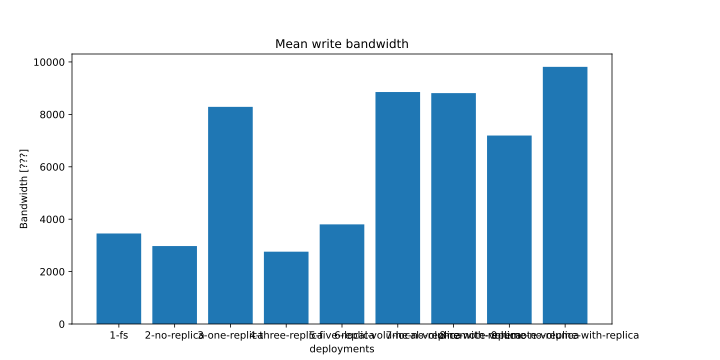

In [12]:
write_bw_means = [d['write_bw_mean'] for d in deployments]
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0.1,0.1,0.75,0.75])
ax.set_title('Mean write bandwidth')
ax.set_xlabel('deployments')
ax.set_ylabel('Bandwidth [???]') # TODO unit
bar = plt.bar(deployments_name, write_bw_means)
img_name = 'figures/write_bw_means.' + figure_format
plt.savefig(img_name, format=figure_format, dpi=figure_dpi)
display(SVG(img_name))

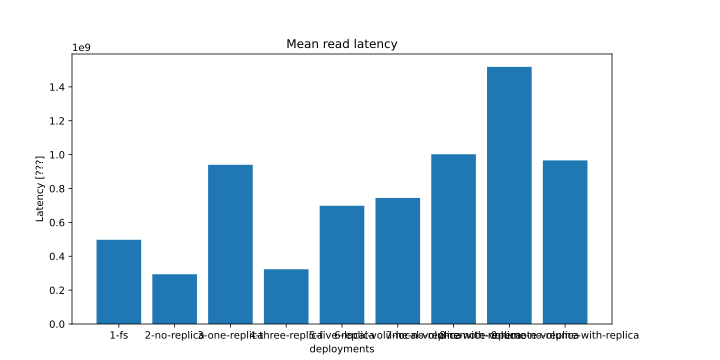

In [13]:
read_lats = [d['read_latency'] for d in deployments]
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0.1,0.1,0.75,0.75])
ax.set_title('Mean read latency')
ax.set_xlabel('deployments')
ax.set_ylabel('Latency [???]') # TODO unit
bar = plt.bar(deployments_name, read_lats)
img_name = 'figures/read_latency_means.' + figure_format
plt.savefig(img_name, format=figure_format, dpi=figure_dpi)
display(SVG(img_name))

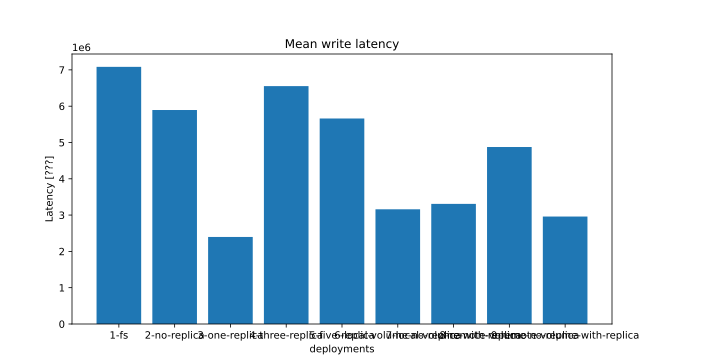

In [14]:
write_lats = [d['write_latency'] for d in deployments]
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0.1,0.1,0.75,0.75])
ax.set_title('Mean write latency')
ax.set_xlabel('deployments')
ax.set_ylabel('Latency [???]') # TODO unit
bar = plt.bar(deployments_name, write_lats)
img_name = 'figures/write_latency_means.' + figure_format
plt.savefig(img_name, format=figure_format, dpi=figure_dpi)
display(SVG(img_name))

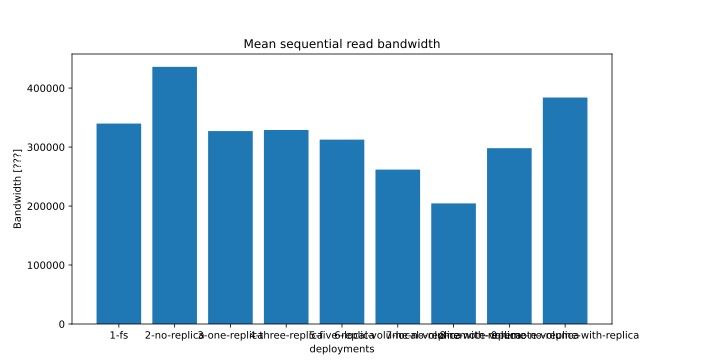

In [15]:
# TODO seq
seq_read_bws = [d['seq_read_bw'] for d in deployments]
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0.1,0.1,0.75,0.75])
ax.set_title('Mean sequential read bandwidth')
ax.set_xlabel('deployments')
ax.set_ylabel('Bandwidth [???]') # TODO unit
bar = plt.bar(deployments_name, seq_read_bws)
img_name = 'figures/seq_read_bandwidth_means.' + figure_format
plt.savefig(img_name, format=figure_format, dpi=figure_dpi)
display(SVG(img_name))

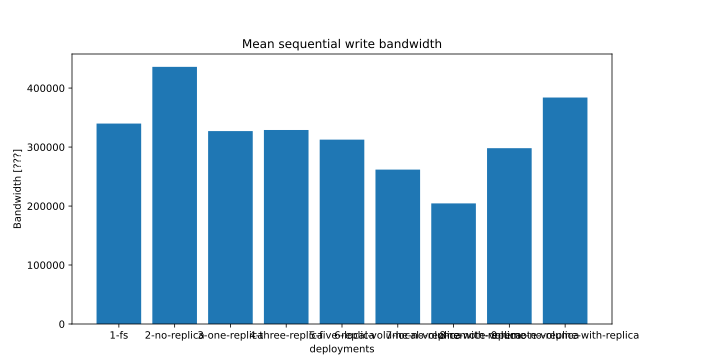

In [16]:
seq_write_bws = [d['seq_write_bw'] for d in deployments]
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0.1,0.1,0.75,0.75])
ax.set_title('Mean sequential write bandwidth')
ax.set_xlabel('deployments')
ax.set_ylabel('Bandwidth [???]') # TODO unit
bar = plt.bar(deployments_name, seq_read_bws)
img_name = 'figures/seq_write_bandwidth_means.' + figure_format
plt.savefig(img_name, format=figure_format, dpi=figure_dpi)
display(SVG(img_name))

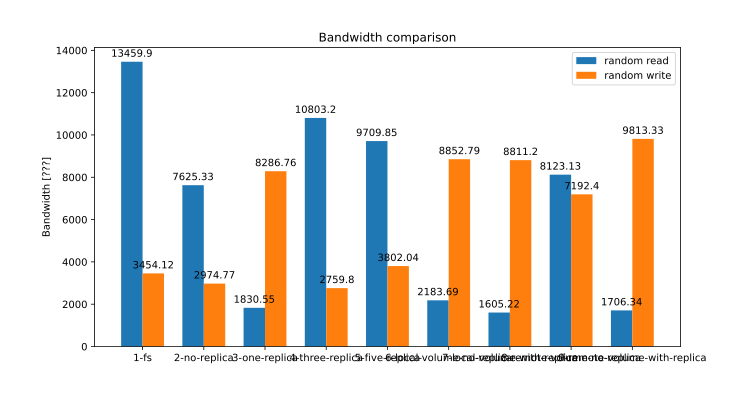

In [17]:
import numpy as np

# TODO grouped bw
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
x = np.arange(len(deployments))
width = 0.35

fig, ax = plt.subplots()
fig.set_size_inches(10.5, 5.5) # manually adjust for names to fit
rects1 = ax.bar(x - width/2, read_bw_means, width=width, label = 'random read')
rects2 = ax.bar(x + width/2, write_bw_means, width=width, label = 'random write')

ax.set_ylabel('Bandwidth [???]') # TODO unit
ax.set_title('Bandwidth comparison')
ax.set_xticks(x)
ax.set_xticklabels(deployments_name)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

# fig.tight_layout()

img_name = 'figures/bandwidth_comparison.' + figure_format
plt.savefig(img_name, format=figure_format, dpi=figure_dpi)
display(SVG(img_name))

# Configuration de Longhorn testée
* replicas
* [data locality](https://longhorn.io/docs/1.1.0/high-availability/data-locality/#data-locality-settings) (replica sur le même node que le workload)
* scheduling policy?
* volumeMode

[I/O operations and replicas](https://longhorn.io/docs/1.1.1/concepts/#231-how-read-and-write-operations-work-for-replicas)

Dans un volume Longhorn, lorsque les opérations I/O sont faites sur une replica, ces opérations se font d'abord sur le live data. Si le bloc cherché n'est pas sur le live data, alors, il va cherché le bloc dans la snapshot la plus récente jusqu'à ce qu'il trouve la bonne snapshot. Une fois trouvé, un index est conservé pour se souvenir de la snapshot la plus récente contenant le bloc recherché.

L'index est conservé en mémoire et a une taille de 1 byte par block de taille 4K.

[taille effective des volumes/replicas/snapshot](https://longhorn.io/docs/1.1.1/volumes-and-nodes/volume-size/#an-example-that-helps-understand-volume-size-and-volume-actual-size)

Au départ, les volumes ne prennent pas de places. Mais après qu'un document soit supprimé du FS dans le volume, cela n'est pas répliqué au niveau bloc: *"The truth of the data#1 deletion is that the data#1 is marked as removed in the filesystem level (For example, inode deletion in ext4). Since Longhorn operates on the block level and does not understand the filesystem, as a result, the disk blocks/space storing data#1 won’t be released after the deletion."*

Est-ce que ce serait intéressant de démontrer ça?

[Longhorn engine par volume](https://longhorn.io/docs/1.1.1/concepts/#11-the-longhorn-manager-and-the-longhorn-engine)

Super intéressant.

[replica par défaut](https://longhorn.io/docs/1.1.1/references/settings/#default-replica-count)

3 apparament??? Est-ce que je peux le vérifier moi-même?

[volumeMode block](https://longhorn.io/docs/0.8.0/examples/block-volume/)

what is this

[PV avec csi option, numberofreplicas](https://longhorn.io/docs/0.8.0/examples/csi-pv/)

[volumeMode: Filesystem](https://github.com/longhorn/longhorn/blob/8318d99136e0d5b39f01a37adf9cae5342034d7e/examples/csi/example_pv.yaml#L8)

[persistentVolumeReclaimPolicy: Delete](https://github.com/longhorn/longhorn/blob/8318d99136e0d5b39f01a37adf9cae5342034d7e/examples/csi/example_pv.yaml#L11)


Note: [google](https://cloud.google.com/compute/docs/disks/benchmarking-pd-performance) persistent disk benchmark

## Nombre de replicas

Par défaut, le nombre de replicas est de 3 tel que montré:

![idk](img/default-pvc-replicas.png)


On va tester les performances lorsqu'il y a 0, 1, 3 (par défaut) et 5 replicas (deployment-03-06).

<u>test 7 pbs</u>
* erreur 1 ligne (0 replica): il y a eu une erreur au test7 qui ne s'est pas reproduit. C'est étrange.
* erreurs multiples (1 replica): fio: io_u error on file /data/fiotest: Read-only file system: read offset=1048576000, buflen=1048576


In [18]:
t = deployment_output(deployment_output_folder_path(True, 3))

## Local/remote volume with/without remote replica

On observer l'efficacité d'un *deployment* avec le *workload* et le volume dans un même *node*, puis sur deux *nodes*. On veut aussi voir comment une *replica* du *volume* affecte les performances lorsque la *replica* se trouve sur le même *node* que le *volume* et lorsque la *replica* est sur un *node* différent du *volume* associé.

On utilise l'attribut *node-selector* pour placer le *workload* sur un *node*. Les *nodes* disponibles sur le cluster sont:
```bash
$ kubectl get node --show-labels
NAME           STATUS   ROLES                      AGE   VERSION   LABELS
10.193.72.32   Ready    controlplane,etcd,worker   45h   v1.19.3   beta.kubernetes.io/arch=amd64,beta.kubernetes.io/os=linux,kubernetes.io/arch=amd64,kubernetes.io/hostname=10.193.72.32,kubernetes.io/os=linux,node-role.kubernetes.io/controlplane=true,node-role.kubernetes.io/etcd=true,node-role.kubernetes.io/worker=true
10.193.72.33   Ready    worker                     45h   v1.19.3   beta.kubernetes.io/arch=amd64,beta.kubernetes.io/os=linux,kubernetes.io/arch=amd64,kubernetes.io/hostname=10.193.72.33,kubernetes.io/os=linux,node-role.kubernetes.io/worker=true
10.193.72.34   Ready    worker                     45h   v1.19.3   beta.kubernetes.io/arch=amd64,beta.kubernetes.io/os=linux,kubernetes.io/arch=amd64,kubernetes.io/hostname=10.193.72.34,kubernetes.io/os=linux,node-role.kubernetes.io/worker=true

```

Chaque node possède un label permettant de les distinguer : `kubernetes.io/hostname`. Ce sera l'argument utilisé dans `node-selector`.

Lorsque l'on veut que le *workload* puisse communiquer avec le *volume* en étant placé sur un *node* différent, on va désactiver le paramètre de [`data locality`](https://longhorn.io/docs/1.1.2/high-availability/data-locality/#data-locality-settings) du *volume*. Dans un des tests, on va laisser `data-locality` à `best-effort` pour garder une *replica* sur le même node que le *workload* et le *volume*.

Contrairement à Architecting-IT, une *StorageClass* ne sera pas utilisé. Chaque volume est créé manuellement depuis le `Longhorn UI` avant d'appliquer le *manifest*. Cela permet d'attacher le volume à un *node*.

### Replica zone level soft anti-affinity
Afin de constater
* l'IOPS au maximum (deployment 06)
* l'effet de séparer le *workload* et le *volume* (deployment 08)

on désire minimiser les effets du networking (`...no-replica`). Pour cela, on active le paramètre [`Replica Zone Level Soft Anti-Affinity`](https://longhorn.io/docs/1.1.2/best-practices/#replica-node-level-soft-anti-affinity) pour autoriser qu'une replica soit sur le même *node* que le *volume* associé.

**Note**: que c'est une mauvaise idée de d'activer [`Replica Zone Level Soft Anti-Affinity`](https://longhorn.io/docs/1.1.2/best-practices/#replica-node-level-soft-anti-affinity) en production parce que si le *node* tombe, alors la *replica* aussi.

### Test
Pour benchmark les *deployments* 6-9, on crée un volume depuis le [Longhorn UI](https://kubernetes.iict.ch/dashboard/c/c-f9654/longhorn) (cliquer sur Longhorn pour être amener à l'UI), dans l'onglet `Volume`, avec les paramètres suivants:

deployment | 06-local-volume-no-replica | 07-local-volume-with-replica | 08-remote-volume-no-replica | 09-remote-volume-with-replica
---- | --- | --- |--- |---
Nom volume | fiobench-vol| fiobench-vol| fiobench-vol| fiobench-vol
Size | 1000Gi| 1000Gi| 1000Gi| 1000Gi
Number of replicas | 1| 1| 1| 1
Frontend | Block device| Block device| Block device| Block device
Data locality | best effort | disabled| disabled| disabled
Access mode | ReadWriteOnce| ReadWriteOnce| ReadWriteOnce| ReadWriteOnce
nodeSelector | node1 | node1 | node2 | node2
Replica Node Level Soft Anti-Affinity (onglet `settings > general` (ne pas oublier de sauver))  | ☑️ | ☐ |☑️ | ☐

Puis on applique le manifest `deployment-XX` associé.

Vous pouvez vérifier que le volume et sa replica sont sur des *nodes* différents en inspectant les détails du volume dans l'UI Longhorn:

![Volume séparé de la replica](img/vol-node-separated.png)

FIXME pourquoi on ne peut pas attacher le volume à un node et nodeSelector le workload à un autre ? Pour le moment, je peux faire des storageClass avec les nodesSelector mais ça ne déplace pas le volume sur le bon node.

* nodeSelector sur une sc, effet (pas le vol, pas replica, longhorn engine??)?
* attach PV mais nodeSelector sur workload empêche (failed to mount) TODO example
* split replica du volume n'est pas guaranti avec 1 replica et soft node anti-affinity
* est-ce qu'il ne faudrait pas 2 replicas avec node soft anti-affinity disabled pour assurer des replicas séparées? When this setting is un-checked, the Longhorn Manager will not allow scheduling on nodes with existing healthy replicas of the same volume. [lien](https://longhorn.io/docs/1.1.2/references/settings/#replica-node-level-soft-anti-affinity)

Note: test 8 config 8 a fail une fois, fio not the best

[instance manager](https://longhorn.io/docs/1.1.2/terminology/#instance-manager) va bouger sur le `nodeSelector`???